# Multimedia Analysis and Indexing – Fall 2017  HW1 

** 王斯泓 r05944025 **

<div class="alert alert-warning" role="alert" style="margin: 10px">
<p>The goal of the homework is to design and implement important components of a content-based image retrieval (CBIR) system. Please evaluate your CBIR system by mean average precision (MAP) on the 25 queries (topics). For each query, you have to calculate the MAP for each modality (or method). Note that the database contains 25 topics (500 images). Those images in the same directory (i.e., the same category) are actually ground truth for each query. Hence, for each query, you can get the MAP over the 20 APs in a leave-one-out manner. Please also report the system MAPs for each modality (or method) by averaging the 25 queries’ MAPs. We are also interested in how the hashed features will affect the retrieval performance. Summarize the results in the table(s) – a sample in the following. The 4 methods (setups) are described below.</p>

<p>Also remember to visualize your query results (at your own and not needed to be submitted) and see if it matches the AP calculation.</p>

<p>You will choose one texture/shape feature and one color feature, decide a similarity or distance metric (e.g., L1 distance, L2 distance, cosine similarity, etc.), and utilize random projection on one of color or textual (shape) features. Please brief the features and the similarity (distance) metric you adopt.</p>

First, define some read and draw image function

In [1]:
import numpy as np
from PIL import Image
import glob
import pickle

def read_image(image_path):
    image = Image.open(image_path)
    image = np.asarray(image)
    return image

def read_images():
    classes = glob.glob('./data/*')
    #print(classes) # ['./data/aloe_vera_gel', './data/baby_shoes'....]

    raw_images = []
    files_name = []
    for classes_path in classes:
        image_paths = glob.glob(f'{classes_path}/*.jpg')
        for image_path in image_paths:
            image = read_image(image_path) # image[0][0] -> array([42, 50, 37], dtype=uint8) RGB
            raw_images.append(image)
            files_name.append(image_path)
    return raw_images, files_name

In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.image as mimage
plt.rcParams.update({'figure.max_open_warning': 0})

def draw_by_path(path, title):
    plt.figure()
    plt.suptitle(title, fontsize=20)
    _img = mimage.imread(path)
    plt.imshow(_img)
    
def draw_grid(ranking, name):
    #gs = gridspec.GridSpec(1, 10, top=1., bottom=0., right=1., left=0., hspace=0., wspace=0.)
    gs = gridspec.GridSpec(1, 10)
    plt.figure(figsize=(15,1))
    plt.suptitle(name, fontsize=10)
    for g, idx in zip(gs, ranking[:10]):            
        ax = plt.subplot(g)
        _img = mimage.imread(files_name[idx])
        ax.imshow(_img)
        ax.set_xticks([])
        ax.set_yticks([])
        if ranking[0] == idx:
            ax.spines['right'].set_color('red')
            ax.spines['left'].set_color('red')
            ax.spines['bottom'].set_color('red')
            ax.spines['top'].set_color('red') 
            ax.set_title("input")
            ax.title.set_color('red')
        #ax.set_aspect('auto')     

Implement the color feature ***to_color_hist()*** by myself. 

In [3]:
def cosine_similarity(a, b):
    a = np.array(a)
    b = np.array(b)
    o = np.dot(a,b.T)
    return o


def L1(target, all_img):
    target = np.array(target)
    all_img = np.array(all_img)
    return np.sum(abs(all_img-target), axis = 1)


def to_color_hist(raw_images, quant_size = 8):
    hist_images = []
    rang = 256 / quant_size
    for count, image in enumerate(raw_images):
        v = [0] * (quant_size * quant_size * quant_size)
        image = np.asarray(image).reshape(-1,3)
        #image = np.asarray(image)
        
        col1 = image[:,0]/rang
        col2 = image[:,1]/rang
        col3 = image[:,2]/rang
        col1, col2, col3 = col1.astype(int), col2.astype(int), col3.astype(int)
        quant_li = col1 + col2*quant_size + col3*quant_size*quant_size
        
        # normalize
        for num in quant_li:
            v[int(num)]+= 1
        
        hist_images.append(v)

    return hist_images

def evaluate(images, files_name, cls = 0, matric = L1):
    if matric == cosine_similarity:
        ascending = -1
    else:
        ascending = 1
    
    from numpy import linalg as LA
    images = [img/LA.norm(img) for img in images]
    
    MAP = 0
    for leave_i in range(20):
        leave_i = 20*cls + leave_i
        score = matric(images[leave_i], images)
        ranking = score.argsort()[::ascending] # [100,120] 第一名的index 第二名的index
        AP = 0
        hit = 0
        count = 0
        for j in ranking:
            if j != leave_i:
                count += 1
                if files_name[j].split('/')[2] == files_name[leave_i].split('/')[2]:
                    hit += 1
                    AP += hit/count
                if hit == 19:
                    break
        MAP += AP/19

    #draw_by_path(files_name[leave_i], "input")
    if cls < 3:
        draw_grid(ranking, files_name[leave_i].split('/')[2])

    return MAP/20

## (1) Color similarity
<div class="alert alert-warning" role="alert" style="margin: 10px">
Color similarity. You can refer to the color features introduced in the lectures, chapter 11 of [Castelli’01] (available in the course webpage), or other relevant papers. Suggestions for color features are (but not limited to): global color histogram, regional color histogram, grid color moments, means in each color channel, color (auto-) correlogram. You need to implement the color feature by yourself.
</div>
測試 global color histogram 效果 metrics 使用 L1, cosine similarity<br>
RGB color quantize 成 8 \* 8 \* 8 維

In [4]:
raw_images, files_name = read_images()
hist_images = to_color_hist(raw_images, quant_size = 8)


In [5]:
import pickle
with open('hist_images.pkl', 'wb') as f:
    pickle.dump(hist_images, f, pickle.HIGHEST_PROTOCOL)
with open('files_name.pkl', 'wb') as f:
    pickle.dump(files_name, f, pickle.HIGHEST_PROTOCOL)

import pickle
with open('files_name.pkl', 'rb') as f:
    files_name = pickle.load(f)

with open('hist_images.pkl', 'rb') as f:
    hist_images = pickle.load(f)

### (1-a) global color histogram 使用 L1

In [6]:
import pandas as pd
df_col = [files_name[i*20].split('/')[2] for i in range(25)] 

df = pd.DataFrame(columns = ["mean"] + df_col)

Mean MAP: 0.2072933449462484


,mean,orange,cup,nba_jersey,minnie_shoes,bracelet,overalls,drum,women_clothes,garment,...,korean_snack,chair,bottle,bicycle,aloe_vera_gel,gge_snack,baby_shoes,men_clothes,minnie_dress,cartoon_purse
RGB histogram L1,0.207293,0.165999,0.211033,0.058625,0.086496,0.300116,0.167764,0.267182,0.422172,0.412659,...,0.20981,0.085952,0.073495,0.195331,0.098693,0.267615,0.277835,0.3359,0.475552,0.136522


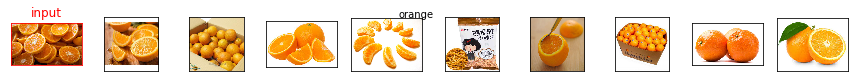

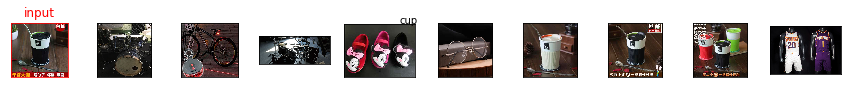

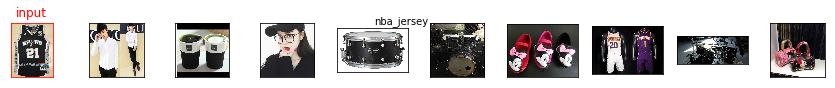

In [7]:
M_MAP = 0
MAP_list = []

for i in range(25):
    MAP = evaluate(hist_images, files_name, i, L1)
    M_MAP += MAP
    MAP_list.append(MAP)
    
df = df.append(pd.DataFrame([MAP_list], columns = df_col))
df = df.rename(index={df.index[-1]: 'RGB histogram L1'})
df['mean'] = df[df_col].mean(axis=1)
df = df[["mean"] + df_col]
print(f"Mean MAP: {M_MAP/25}")
df

color feature 的表現基本上還不錯

### (1-b) global color histogram 使用 cosine similarity

Mean MAP: 0.17965510932630188


,mean,orange,cup,nba_jersey,minnie_shoes,bracelet,overalls,drum,women_clothes,garment,...,korean_snack,chair,bottle,bicycle,aloe_vera_gel,gge_snack,baby_shoes,men_clothes,minnie_dress,cartoon_purse
RGB histogram L1,0.207293,0.165999,0.211033,0.058625,0.086496,0.300116,0.167764,0.267182,0.422172,0.412659,...,0.20981,0.085952,0.073495,0.195331,0.098693,0.267615,0.277835,0.335900,0.475552,0.136522
RGB histogram cosine similarity,0.179655,0.132229,0.239930,0.042227,0.080224,0.255051,0.117414,0.194704,0.359209,0.390575,...,0.16483,0.128941,0.104400,0.163302,0.103773,0.236242,0.272354,0.237977,0.374134,0.125143


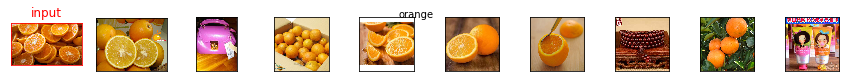

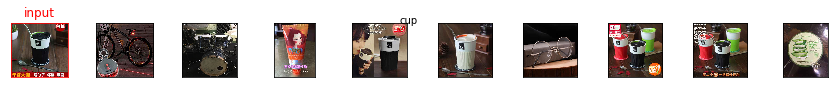

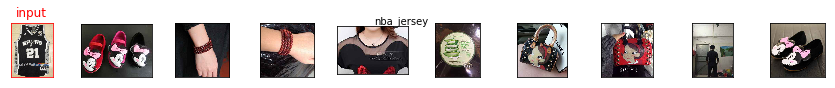

In [8]:
M_MAP = 0
MAP_list = []

for i in range(25):
    MAP = evaluate(hist_images, files_name, i, cosine_similarity)
    M_MAP += MAP
    MAP_list.append(MAP)
    
df = df.append(pd.DataFrame([MAP_list], columns = df_col))
df = df.rename(index={df.index[-1]: 'RGB histogram cosine similarity'})
df['mean'] = df[df_col].mean(axis=1)
df = df[["mean"] + df_col]
print(f"Mean MAP: {M_MAP/25}")
df

### (1-c) HSV 使用 L1

Quantize HSV to 18 \* 4 \* 4

Mean MAP: 0.20705529029150566


,mean,orange,cup,nba_jersey,minnie_shoes,bracelet,overalls,drum,women_clothes,garment,...,korean_snack,chair,bottle,bicycle,aloe_vera_gel,gge_snack,baby_shoes,men_clothes,minnie_dress,cartoon_purse
RGB histogram L1,0.207293,0.165999,0.211033,0.058625,0.086496,0.300116,0.167764,0.267182,0.422172,0.412659,...,0.209810,0.085952,0.073495,0.195331,0.098693,0.267615,0.277835,0.335900,0.475552,0.136522
RGB histogram cosine similarity,0.179655,0.132229,0.239930,0.042227,0.080224,0.255051,0.117414,0.194704,0.359209,0.390575,...,0.164830,0.128941,0.104400,0.163302,0.103773,0.236242,0.272354,0.237977,0.374134,0.125143
HSV L1,0.207055,0.295281,0.218418,0.070970,0.118558,0.112024,0.209106,0.190438,0.324579,0.394702,...,0.316733,0.071323,0.131479,0.195804,0.113048,0.207572,0.300880,0.324853,0.460553,0.131539


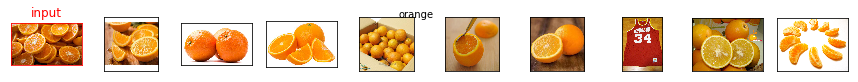

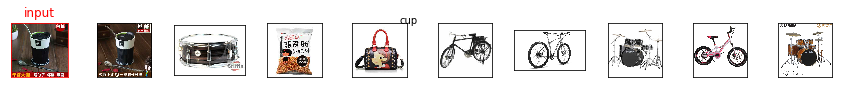

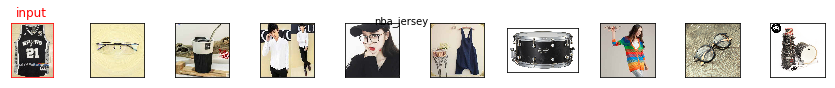

In [9]:
import cv2
def get_HSV():
    classes = glob.glob('./data/*') #['./data/aloe_vera_gel', './data/baby_shoes'....]

    hsv_pic = []
    for classes_path in classes:
        image_paths = glob.glob(f'{classes_path}/*.jpg')
        for image_path in image_paths:
            img = cv2.imread(image_path)
            img = cv2.resize(img, (128, 128))
            img = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
            
            v = [0] * (18 * 4 * 4)
            img = np.asarray(img).reshape(-1,3)
            #image = np.asarray(image)

            col1 = img[:,0]/(180/18)
            col2 = img[:,1]/(256/4)
            col3 = img[:,2]/(256/4)
            col1, col2, col3 = col1.astype(int), col2.astype(int), col3.astype(int)
            quant_li = col1 + col2*18 + col3*18*4

            # normalize
            for num in quant_li:
                v[int(num)]+= 1
            hsv_pic.append(v)
    return hsv_pic

hsv_pic = get_HSV()
M_MAP = 0
MAP_list = []

for i in range(25):
    MAP = evaluate(hsv_pic, files_name, i, L1)
    M_MAP += MAP
    MAP_list.append(MAP)
    
df = df.append(pd.DataFrame([MAP_list], columns = df_col))
df = df.rename(index={df.index[-1]: 'HSV L1'})
df['mean'] = df[df_col].mean(axis=1)
df = df[["mean"] + df_col]
print(f"Mean MAP: {M_MAP/25}")
df

轉換成 HSV 後的表現，與 RGB 差異不大

### (1-c) HSV 使用 cosine similarity

Mean MAP: 0.38973142196251515


,mean,orange,cup,nba_jersey,minnie_shoes,bracelet,overalls,drum,women_clothes,garment,...,korean_snack,chair,bottle,bicycle,aloe_vera_gel,gge_snack,baby_shoes,men_clothes,minnie_dress,cartoon_purse
RGB histogram L1,0.207293,0.165999,0.211033,0.058625,0.086496,0.300116,0.167764,0.267182,0.422172,0.412659,...,0.209810,0.085952,0.073495,0.195331,0.098693,0.267615,0.277835,0.335900,0.475552,0.136522
RGB histogram cosine similarity,0.179655,0.132229,0.239930,0.042227,0.080224,0.255051,0.117414,0.194704,0.359209,0.390575,...,0.164830,0.128941,0.104400,0.163302,0.103773,0.236242,0.272354,0.237977,0.374134,0.125143
HSV L1,0.207055,0.295281,0.218418,0.070970,0.118558,0.112024,0.209106,0.190438,0.324579,0.394702,...,0.316733,0.071323,0.131479,0.195804,0.113048,0.207572,0.300880,0.324853,0.460553,0.131539
HSV cosine similarity,0.182676,0.261357,0.310176,0.049465,0.130844,0.111499,0.144900,0.161859,0.230007,0.354132,...,0.205918,0.107902,0.195009,0.173422,0.126108,0.168005,0.245284,0.260901,0.335383,0.112569


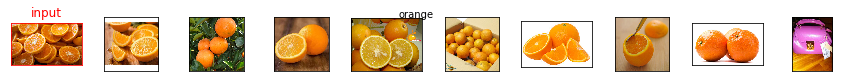

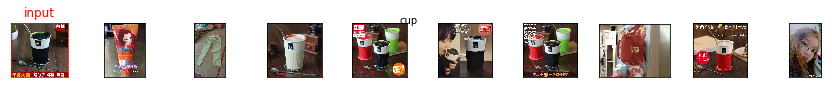

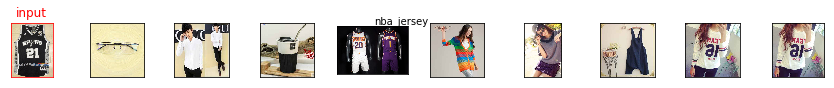

In [10]:
MAP_list = []
for i in range(25):
    MAP = evaluate(hsv_pic, files_name, i, cosine_similarity)
    M_MAP += MAP
    MAP_list.append(MAP)
    
df = df.append(pd.DataFrame([MAP_list], columns = df_col))
df = df.rename(index={df.index[-1]: 'HSV cosine similarity'})
df['mean'] = df[df_col].mean(axis=1)
df = df[["mean"] + df_col]
print(f"Mean MAP: {M_MAP/25}")
df

## (2) Texture/shape similarity
<div class="alert alert-warning" role="alert" style="margin: 10px">
Texture/shape similarity. You can choose any texture or shape features. Suggestions for such features are (but not limited to): Fourier features, Laws’ texture measures, co-occurrence matrix metrics, Tamura’s textures, Gabor texture, PHOG, gradient histogram, edge histogram, etc. You are encouraged to implement on your own or can find other open source tools for texture or shape features; however, you have to acknowledge the source of the tools.
</div>
try on frequency response and Gabor

### Tool: OpenCV

In [11]:
import cv2
def get_freq_hist():
    classes = glob.glob('./data/*') #['./data/aloe_vera_gel', './data/baby_shoes'....]

    freq_hist = []
    for classes_path in classes:
        image_paths = glob.glob(f'{classes_path}/*.jpg')
        for image_path in image_paths:
            img = cv2.imread(image_path,0) #GBR
            img = cv2.resize(img, (128, 128))
            f = np.fft.fft2(img)
            fshift = np.fft.fftshift(f)
            magnitude_spectrum = 20*np.log(np.abs(fshift))
            magnitude_spectrum = magnitude_spectrum.reshape((-1))
            freq_hist.append(magnitude_spectrum.tolist())
            
    return freq_hist


### (2-a) 先測試freq response

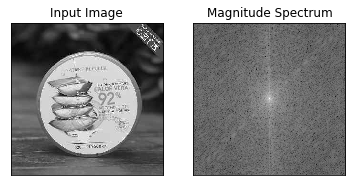

In [12]:
img = cv2.imread("./data/aloe_vera_gel/aloe_vera_gel_1.jpg", 0) #GBR
f = np.fft.fft2(img)
fshift = np.fft.fftshift(f)
magnitude_spectrum = 20*np.log(np.abs(fshift))
#plt.figure()
plt.subplot(121),plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()

### (2-b) frequency response 使用 L1

Mean MAP: 0.13538838907008702


,mean,orange,cup,nba_jersey,minnie_shoes,bracelet,overalls,drum,women_clothes,garment,...,korean_snack,chair,bottle,bicycle,aloe_vera_gel,gge_snack,baby_shoes,men_clothes,minnie_dress,cartoon_purse
RGB histogram L1,0.207293,0.165999,0.211033,0.058625,0.086496,0.300116,0.167764,0.267182,0.422172,0.412659,...,0.209810,0.085952,0.073495,0.195331,0.098693,0.267615,0.277835,0.335900,0.475552,0.136522
RGB histogram cosine similarity,0.179655,0.132229,0.239930,0.042227,0.080224,0.255051,0.117414,0.194704,0.359209,0.390575,...,0.164830,0.128941,0.104400,0.163302,0.103773,0.236242,0.272354,0.237977,0.374134,0.125143
HSV L1,0.207055,0.295281,0.218418,0.070970,0.118558,0.112024,0.209106,0.190438,0.324579,0.394702,...,0.316733,0.071323,0.131479,0.195804,0.113048,0.207572,0.300880,0.324853,0.460553,0.131539
HSV cosine similarity,0.182676,0.261357,0.310176,0.049465,0.130844,0.111499,0.144900,0.161859,0.230007,0.354132,...,0.205918,0.107902,0.195009,0.173422,0.126108,0.168005,0.245284,0.260901,0.335383,0.112569
frequency response L1,0.135388,0.031493,0.118622,0.124440,0.167165,0.048899,0.094146,0.106243,0.066211,0.174322,...,0.345774,0.070155,0.112323,0.282176,0.066958,0.627964,0.050748,0.177868,0.125408,0.074448


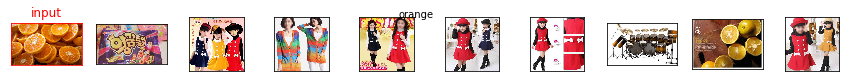

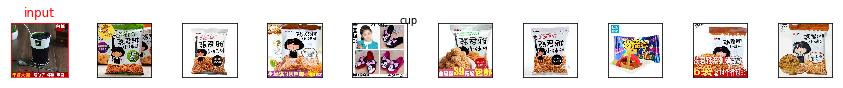

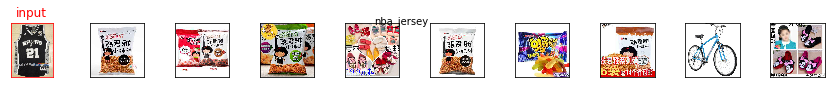

In [13]:
freq_hist = get_freq_hist()
M_MAP = 0
MAP_list = []

for i in range(25):
    MAP = evaluate(freq_hist, files_name, i, L1)
    M_MAP += MAP
    MAP_list.append(MAP)
    
df = df.append(pd.DataFrame([MAP_list], columns = df_col))
df = df.rename(index={df.index[-1]: 'frequency response L1'})
df['mean'] = df[df_col].mean(axis=1)
df = df[["mean"] + df_col]
print(f"Mean MAP: {M_MAP/25}")
df

### (2-c) Gabor feature

In [14]:
#!/usr/bin/env python
 
import numpy as np
import cv2
 
def draw_gabor(image1, image2):
    plt.subplot(121),plt.imshow(image1, cmap='gray')
    plt.title('Input Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(image2, cmap='gray')
    plt.title('Gabor'), plt.xticks([]), plt.yticks([])
    plt.show()
    
def draw_img(img, title):
    plt.figure(figsize=(1,1))
    plt.imshow(img, cmap='gray')#, cmap = 'gray')
    plt.title(title), plt.xticks([]), plt.yticks([])
    plt.show()
    
def build_filters():
    filters = []
    #ksize = 31
    ksize = 21
    #for theta in np.arange(0, np.pi, np.pi / 16):
    for theta in np.arange(0, np.pi, np.pi / 4):
        kern = cv2.getGaborKernel((ksize, ksize), 4.0, theta, 10.0, 0.5, 0, ktype=cv2.CV_32F) #Size ksize, double sigma, double theta
        kern /= 1.5*kern.sum()
        #draw_gabor(kern, cv2.getGaborKernel((ksize, ksize), 8.0, theta, 10.0, 0.5, 0, ktype=cv2.CV_32F))
        filters.append(kern)
    return filters
 
def process(img, filters):
    accum = np.zeros_like(img)
    for kern in filters:
        fimg = cv2.filter2D(img, cv2.CV_8UC3, kern)
        np.maximum(accum, fimg, accum) # (a, b, c) save to c'''
    return accum

def get_gabor_pic():
    classes = glob.glob('./data/*') #['./data/aloe_vera_gel', './data/baby_shoes'....]

    gabor_hist = []
    for classes_path in classes:
        image_paths = glob.glob(f'{classes_path}/*.jpg')
        for image_path in image_paths:
            img = cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (128, 128))
            #print(img.shape)
            filters = build_filters()
            res1 = process(img, filters)
            gabor_hist.append(res1.reshape(-1).tolist())
            
    return gabor_hist

def process_to_hist(img, filters):
    accum = np.zeros_like(img)
    hist = []
    for kern in filters:
        fimg = cv2.filter2D(img, cv2.CV_8UC3, kern)
        fimg = fimg.reshape(-1)
        hist.append(sum(fimg))
    return hist

def get_gabor_hist():
    classes = glob.glob('./data/*') #['./data/aloe_vera_gel', './data/baby_shoes'....]

    gabor_hist = []
    for classes_path in classes:
        image_paths = glob.glob(f'{classes_path}/*.jpg')
        print(classes_path)
        for image_path in image_paths:
            img = cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (128, 128))
            #print(img.shape)
            filters = build_filters()
            his = process_to_hist(img, filters)
            his = np.asarray(his)
            gabor_hist.append(his.reshape(-1))
    return gabor_hist


### (2-c) draw Gabor filter

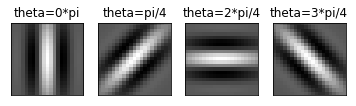

In [15]:
fil = build_filters()
    
plt.figure()
plt.subplot(141),plt.imshow(fil[0], cmap = 'gray')
plt.title('theta=0*pi'), plt.xticks([]), plt.yticks([])
plt.subplot(142),plt.imshow(fil[1], cmap = 'gray')
plt.title('theta=pi/4'), plt.xticks([]), plt.yticks([])
plt.subplot(143),plt.imshow(fil[2], cmap = 'gray')
plt.title('theta=2*pi/4'), plt.xticks([]), plt.yticks([])
plt.subplot(144),plt.imshow(fil[3], cmap = 'gray')
plt.title('theta=3*pi/4'), plt.xticks([]), plt.yticks([])

plt.show()

### (2-d) 先在 Zebra 圖片上測試 Gabor filter

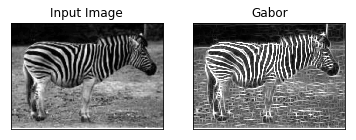

In [16]:
img_fn = './zebra.png'
img = cv2.imread(img_fn, cv2.IMREAD_GRAYSCALE)
filters = build_filters()
res1 = process(img, filters)
draw_gabor(img, res1)

### (2-e) Gabor filter 使用 L1

Mean MAP: 0.1244046985818797


,mean,orange,cup,nba_jersey,minnie_shoes,bracelet,overalls,drum,women_clothes,garment,...,korean_snack,chair,bottle,bicycle,aloe_vera_gel,gge_snack,baby_shoes,men_clothes,minnie_dress,cartoon_purse
RGB histogram L1,0.207293,0.165999,0.211033,0.058625,0.086496,0.300116,0.167764,0.267182,0.422172,0.412659,...,0.209810,0.085952,0.073495,0.195331,0.098693,0.267615,0.277835,0.335900,0.475552,0.136522
RGB histogram cosine similarity,0.179655,0.132229,0.239930,0.042227,0.080224,0.255051,0.117414,0.194704,0.359209,0.390575,...,0.164830,0.128941,0.104400,0.163302,0.103773,0.236242,0.272354,0.237977,0.374134,0.125143
HSV L1,0.207055,0.295281,0.218418,0.070970,0.118558,0.112024,0.209106,0.190438,0.324579,0.394702,...,0.316733,0.071323,0.131479,0.195804,0.113048,0.207572,0.300880,0.324853,0.460553,0.131539
HSV cosine similarity,0.182676,0.261357,0.310176,0.049465,0.130844,0.111499,0.144900,0.161859,0.230007,0.354132,...,0.205918,0.107902,0.195009,0.173422,0.126108,0.168005,0.245284,0.260901,0.335383,0.112569
frequency response L1,0.135388,0.031493,0.118622,0.124440,0.167165,0.048899,0.094146,0.106243,0.066211,0.174322,...,0.345774,0.070155,0.112323,0.282176,0.066958,0.627964,0.050748,0.177868,0.125408,0.074448
Gabor L1,0.124405,0.075222,0.063188,0.047971,0.051679,0.110307,0.171186,0.083632,0.281264,0.196208,...,0.061071,0.069815,0.073508,0.141393,0.159512,0.109911,0.229658,0.084874,0.109307,0.050488


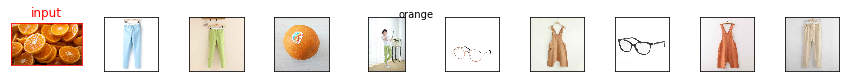

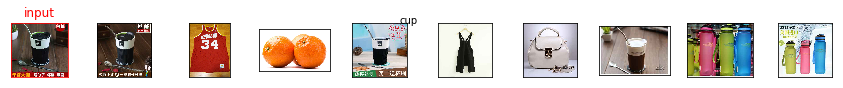

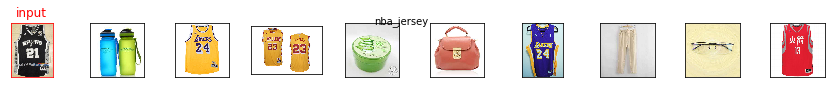

In [17]:
#gabor_hist = get_gabor_hist()
gabor_hist = get_gabor_pic()

M_MAP = 0
MAP_list = []

for i in range(25):
    MAP = evaluate(gabor_hist, files_name, i, L1)
    M_MAP += MAP
    MAP_list.append(MAP)
    
df = df.append(pd.DataFrame([MAP_list], columns = df_col))
df = df.rename(index={df.index[-1]: 'Gabor L1'})
df['mean'] = df[df_col].mean(axis=1)
df = df[["mean"] + df_col]
print(f"Mean MAP: {M_MAP/25}")
df

## (3) Performance on fusing the both features
<div class="alert alert-warning" role="alert" style="margin: 10px">
Performance for fusing the both features in (1) and (2). There are many fusing methods mentioned in the lecture. Do take care of the normalization mechanisms before the fusion. Also report the performance over 25 MAPs and the overall MAP.
</div>

Mean MAP: 0.14171883140667016


,mean,orange,cup,nba_jersey,minnie_shoes,bracelet,overalls,drum,women_clothes,garment,...,korean_snack,chair,bottle,bicycle,aloe_vera_gel,gge_snack,baby_shoes,men_clothes,minnie_dress,cartoon_purse
RGB histogram L1,0.207293,0.165999,0.211033,0.058625,0.086496,0.300116,0.167764,0.267182,0.422172,0.412659,...,0.209810,0.085952,0.073495,0.195331,0.098693,0.267615,0.277835,0.335900,0.475552,0.136522
RGB histogram cosine similarity,0.179655,0.132229,0.239930,0.042227,0.080224,0.255051,0.117414,0.194704,0.359209,0.390575,...,0.164830,0.128941,0.104400,0.163302,0.103773,0.236242,0.272354,0.237977,0.374134,0.125143
HSV L1,0.207055,0.295281,0.218418,0.070970,0.118558,0.112024,0.209106,0.190438,0.324579,0.394702,...,0.316733,0.071323,0.131479,0.195804,0.113048,0.207572,0.300880,0.324853,0.460553,0.131539
HSV cosine similarity,0.182676,0.261357,0.310176,0.049465,0.130844,0.111499,0.144900,0.161859,0.230007,0.354132,...,0.205918,0.107902,0.195009,0.173422,0.126108,0.168005,0.245284,0.260901,0.335383,0.112569
frequency response L1,0.135388,0.031493,0.118622,0.124440,0.167165,0.048899,0.094146,0.106243,0.066211,0.174322,...,0.345774,0.070155,0.112323,0.282176,0.066958,0.627964,0.050748,0.177868,0.125408,0.074448
Gabor L1,0.124405,0.075222,0.063188,0.047971,0.051679,0.110307,0.171186,0.083632,0.281264,0.196208,...,0.061071,0.069815,0.073508,0.141393,0.159512,0.109911,0.229658,0.084874,0.109307,0.050488
fusion feature L1,0.141719,0.076454,0.076321,0.233682,0.076774,0.098412,0.112146,0.137532,0.208316,0.328260,...,0.084090,0.070114,0.096621,0.146020,0.130505,0.157412,0.205140,0.132508,0.153012,0.064261


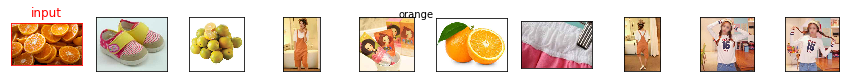

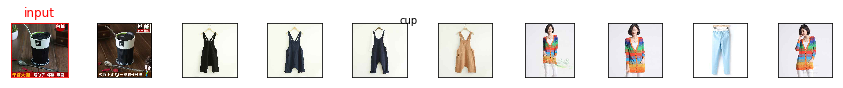

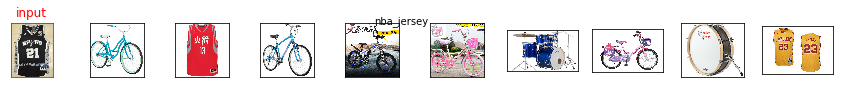

In [18]:
fusion_feature = [i+j for i,j in zip(hist_images, gabor_hist)]

M_MAP = 0
MAP_list = []

for i in range(25):
    MAP = evaluate(fusion_feature, files_name, i, L1)
    M_MAP += MAP
    MAP_list.append(MAP)
    
df = df.append(pd.DataFrame([MAP_list], columns = df_col))
df = df.rename(index={df.index[-1]: 'fusion feature L1'})
df['mean'] = df[df_col].mean(axis=1)
df = df[["mean"] + df_col]
print(f"Mean MAP: {M_MAP/25}")
df

## (4) Random projection
<div class="alert alert-warning" role="alert" style="margin: 10px">
Random projection on color or texture (shape) feature; pick up one you prefer. Please show the retrieval performance (25 MAPs and the mean of MAPs) for the hashed features with 25% and 50% of the original feature dimensions.
</div>
 Random projection on color or texture (shape) feature; pick up one you prefer. Please show the retrieval performance (25 MAPs and the mean of MAPs) for the hashed features with 25% and 50% of the original feature dimensions.

#### Random projection hashed color features with 25%

Mean MAP: 0.17803769185454082


,mean,orange,cup,nba_jersey,minnie_shoes,bracelet,overalls,drum,women_clothes,garment,...,korean_snack,chair,bottle,bicycle,aloe_vera_gel,gge_snack,baby_shoes,men_clothes,minnie_dress,cartoon_purse
RGB histogram L1,0.207293,0.165999,0.211033,0.058625,0.086496,0.300116,0.167764,0.267182,0.422172,0.412659,...,0.209810,0.085952,0.073495,0.195331,0.098693,0.267615,0.277835,0.335900,0.475552,0.136522
RGB histogram cosine similarity,0.179655,0.132229,0.239930,0.042227,0.080224,0.255051,0.117414,0.194704,0.359209,0.390575,...,0.164830,0.128941,0.104400,0.163302,0.103773,0.236242,0.272354,0.237977,0.374134,0.125143
HSV L1,0.207055,0.295281,0.218418,0.070970,0.118558,0.112024,0.209106,0.190438,0.324579,0.394702,...,0.316733,0.071323,0.131479,0.195804,0.113048,0.207572,0.300880,0.324853,0.460553,0.131539
HSV cosine similarity,0.182676,0.261357,0.310176,0.049465,0.130844,0.111499,0.144900,0.161859,0.230007,0.354132,...,0.205918,0.107902,0.195009,0.173422,0.126108,0.168005,0.245284,0.260901,0.335383,0.112569
frequency response L1,0.135388,0.031493,0.118622,0.124440,0.167165,0.048899,0.094146,0.106243,0.066211,0.174322,...,0.345774,0.070155,0.112323,0.282176,0.066958,0.627964,0.050748,0.177868,0.125408,0.074448
Gabor L1,0.124405,0.075222,0.063188,0.047971,0.051679,0.110307,0.171186,0.083632,0.281264,0.196208,...,0.061071,0.069815,0.073508,0.141393,0.159512,0.109911,0.229658,0.084874,0.109307,0.050488
fusion feature L1,0.141719,0.076454,0.076321,0.233682,0.076774,0.098412,0.112146,0.137532,0.208316,0.328260,...,0.084090,0.070114,0.096621,0.146020,0.130505,0.157412,0.205140,0.132508,0.153012,0.064261
RP(25%),0.178038,0.139470,0.224784,0.050335,0.084039,0.228759,0.118098,0.180014,0.354015,0.389561,...,0.180157,0.134674,0.106733,0.164581,0.100222,0.245504,0.261118,0.266821,0.368281,0.126409


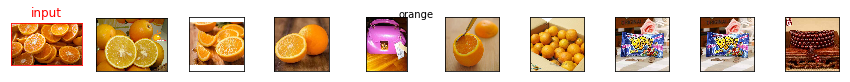

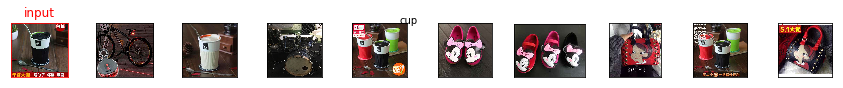

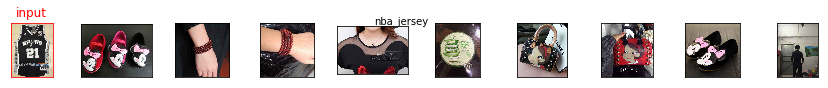

In [19]:
import numpy as np
from sklearn import random_projection

hist_images = np.asarray(hist_images) #(500,512) 500*512
transformer = random_projection.GaussianRandomProjection(int(hist_images.shape[1]*0.25))
X_new = transformer.fit_transform(hist_images)

M_MAP = 0
MAP_list = []

for i in range(25):
    MAP = evaluate(X_new, files_name, i, L1)
    M_MAP += MAP
    MAP_list.append(MAP)
    
df = df.append(pd.DataFrame([MAP_list], columns = df_col))
df = df.rename(index={df.index[-1]: 'RP(25%)'})
df['mean'] = df[df_col].mean(axis=1)
df = df[["mean"] + df_col]
print(f"Mean MAP: {M_MAP/25}")
df

#### Random projection hashed color features with 50%

Mean MAP: 0.17494369545496039


,mean,orange,cup,nba_jersey,minnie_shoes,bracelet,overalls,drum,women_clothes,garment,...,korean_snack,chair,bottle,bicycle,aloe_vera_gel,gge_snack,baby_shoes,men_clothes,minnie_dress,cartoon_purse
RGB histogram L1,0.207293,0.165999,0.211033,0.058625,0.086496,0.300116,0.167764,0.267182,0.422172,0.412659,...,0.209810,0.085952,0.073495,0.195331,0.098693,0.267615,0.277835,0.335900,0.475552,0.136522
RGB histogram cosine similarity,0.179655,0.132229,0.239930,0.042227,0.080224,0.255051,0.117414,0.194704,0.359209,0.390575,...,0.164830,0.128941,0.104400,0.163302,0.103773,0.236242,0.272354,0.237977,0.374134,0.125143
HSV L1,0.207055,0.295281,0.218418,0.070970,0.118558,0.112024,0.209106,0.190438,0.324579,0.394702,...,0.316733,0.071323,0.131479,0.195804,0.113048,0.207572,0.300880,0.324853,0.460553,0.131539
HSV cosine similarity,0.182676,0.261357,0.310176,0.049465,0.130844,0.111499,0.144900,0.161859,0.230007,0.354132,...,0.205918,0.107902,0.195009,0.173422,0.126108,0.168005,0.245284,0.260901,0.335383,0.112569
frequency response L1,0.135388,0.031493,0.118622,0.124440,0.167165,0.048899,0.094146,0.106243,0.066211,0.174322,...,0.345774,0.070155,0.112323,0.282176,0.066958,0.627964,0.050748,0.177868,0.125408,0.074448
Gabor L1,0.124405,0.075222,0.063188,0.047971,0.051679,0.110307,0.171186,0.083632,0.281264,0.196208,...,0.061071,0.069815,0.073508,0.141393,0.159512,0.109911,0.229658,0.084874,0.109307,0.050488
fusion feature L1,0.141719,0.076454,0.076321,0.233682,0.076774,0.098412,0.112146,0.137532,0.208316,0.328260,...,0.084090,0.070114,0.096621,0.146020,0.130505,0.157412,0.205140,0.132508,0.153012,0.064261
RP(25%),0.178038,0.139470,0.224784,0.050335,0.084039,0.228759,0.118098,0.180014,0.354015,0.389561,...,0.180157,0.134674,0.106733,0.164581,0.100222,0.245504,0.261118,0.266821,0.368281,0.126409
RP(50%),0.174944,0.136431,0.236917,0.041152,0.079449,0.237573,0.110986,0.201729,0.356757,0.392078,...,0.151094,0.126084,0.079974,0.161481,0.094746,0.236737,0.251151,0.235057,0.374725,0.121574


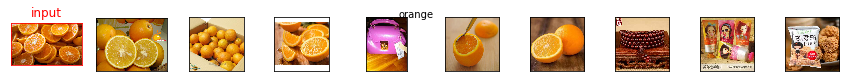

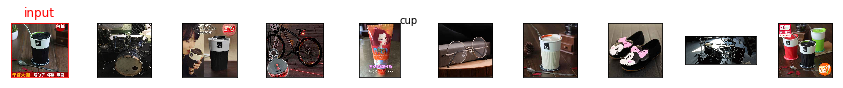

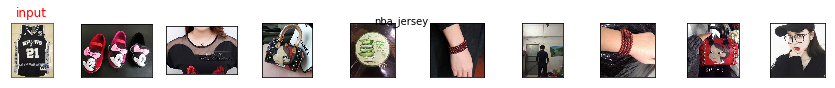

In [20]:
import numpy as np
from sklearn import random_projection

hist_images = np.asarray(hist_images) #(500,512) 500*512
transformer = random_projection.GaussianRandomProjection(int(hist_images.shape[1]*0.5))
X_new = transformer.fit_transform(hist_images)

M_MAP = 0
MAP_list = []

for i in range(25):
    MAP = evaluate(X_new, files_name, i, L1)
    M_MAP += MAP
    MAP_list.append(MAP)
    
df = df.append(pd.DataFrame([MAP_list], columns = df_col))
df = df.rename(index={df.index[-1]: 'RP(50%)'})
df['mean'] = df[df_col].mean(axis=1)
df = df[["mean"] + df_col]
print(f"Mean MAP: {M_MAP/25}")
df

### test on deep feature by using InceptionV3

In [21]:
from keras.applications import VGG16
from keras.applications import InceptionV3
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import numpy as np

model = InceptionV3(weights='imagenet', include_top=False)

def get_deep_feature():
    classes = glob.glob('./data/*') #['./data/aloe_vera_gel', './data/baby_shoes'....]

    deep_feature = []
    for classes_path in classes:
        image_paths = glob.glob(f'{classes_path}/*.jpg')
        print(classes_path)
        for image_path in image_paths:
            img = image.load_img(image_path, target_size=(224, 224))
            x = image.img_to_array(img)
            x = np.expand_dims(x, axis=0)
            x = preprocess_input(x)

            features = model.predict(x)
            features = features.flatten()
            deep_feature.append(features.tolist())
    return deep_feature


Using TensorFlow backend.
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [22]:
deep_feature = get_deep_feature()


./data/orange
./data/cup
./data/nba_jersey
./data/minnie_shoes
./data/bracelet
./data/overalls
./data/drum
./data/women_clothes
./data/garment
./data/children_dress
./data/trousers
./data/hand_cream
./data/skirt
./data/glasses
./data/leather_purse
./data/korean_snack
./data/chair
./data/bottle
./data/bicycle
./data/aloe_vera_gel
./data/gge_snack
./data/baby_shoes
./data/men_clothes
./data/minnie_dress
./data/cartoon_purse


Mean MAP: 0.19597661240646236


,mean,orange,cup,nba_jersey,minnie_shoes,bracelet,overalls,drum,women_clothes,garment,...,korean_snack,chair,bottle,bicycle,aloe_vera_gel,gge_snack,baby_shoes,men_clothes,minnie_dress,cartoon_purse
RGB histogram L1,0.207293,0.165999,0.211033,0.058625,0.086496,0.300116,0.167764,0.267182,0.422172,0.412659,...,0.209810,0.085952,0.073495,0.195331,0.098693,0.267615,0.277835,0.335900,0.475552,0.136522
RGB histogram cosine similarity,0.179655,0.132229,0.239930,0.042227,0.080224,0.255051,0.117414,0.194704,0.359209,0.390575,...,0.164830,0.128941,0.104400,0.163302,0.103773,0.236242,0.272354,0.237977,0.374134,0.125143
HSV L1,0.207055,0.295281,0.218418,0.070970,0.118558,0.112024,0.209106,0.190438,0.324579,0.394702,...,0.316733,0.071323,0.131479,0.195804,0.113048,0.207572,0.300880,0.324853,0.460553,0.131539
HSV cosine similarity,0.182676,0.261357,0.310176,0.049465,0.130844,0.111499,0.144900,0.161859,0.230007,0.354132,...,0.205918,0.107902,0.195009,0.173422,0.126108,0.168005,0.245284,0.260901,0.335383,0.112569
frequency response L1,0.135388,0.031493,0.118622,0.124440,0.167165,0.048899,0.094146,0.106243,0.066211,0.174322,...,0.345774,0.070155,0.112323,0.282176,0.066958,0.627964,0.050748,0.177868,0.125408,0.074448
Gabor L1,0.124405,0.075222,0.063188,0.047971,0.051679,0.110307,0.171186,0.083632,0.281264,0.196208,...,0.061071,0.069815,0.073508,0.141393,0.159512,0.109911,0.229658,0.084874,0.109307,0.050488
fusion feature L1,0.141719,0.076454,0.076321,0.233682,0.076774,0.098412,0.112146,0.137532,0.208316,0.328260,...,0.084090,0.070114,0.096621,0.146020,0.130505,0.157412,0.205140,0.132508,0.153012,0.064261
RP(25%),0.178038,0.139470,0.224784,0.050335,0.084039,0.228759,0.118098,0.180014,0.354015,0.389561,...,0.180157,0.134674,0.106733,0.164581,0.100222,0.245504,0.261118,0.266821,0.368281,0.126409
RP(50%),0.174944,0.136431,0.236917,0.041152,0.079449,0.237573,0.110986,0.201729,0.356757,0.392078,...,0.151094,0.126084,0.079974,0.161481,0.094746,0.236737,0.251151,0.235057,0.374725,0.121574
Deep feature L1,0.195977,0.106289,0.301679,0.059396,0.130032,0.312337,0.169934,0.124224,0.288427,0.357898,...,0.293498,0.146753,0.156959,0.134499,0.137560,0.288786,0.217135,0.167607,0.328483,0.128871


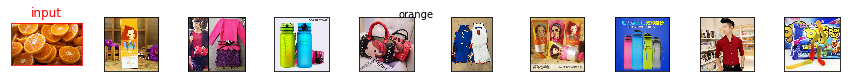

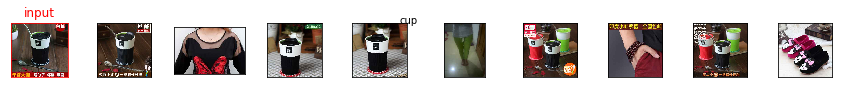

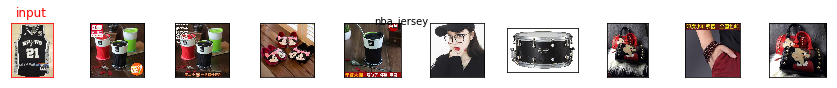

In [23]:
M_MAP = 0
MAP_list = []

for i in range(25):
    MAP = evaluate(deep_feature, files_name, i, cosine_similarity)
    M_MAP += MAP
    MAP_list.append(MAP)
    
df = df.append(pd.DataFrame([MAP_list], columns = df_col))
df = df.rename(index={df.index[-1]: 'Deep feature L1'})
df['mean'] = df[df_col].mean(axis=1)
df = df[["mean"] + df_col]
print(f"Mean MAP: {M_MAP/25}")
df

### test on deep feature with random_projection

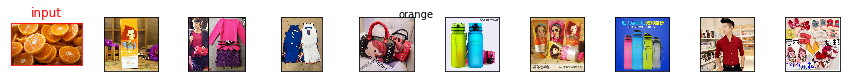

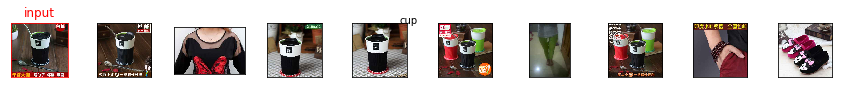

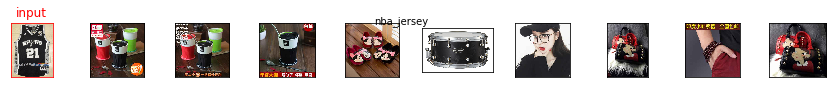

In [24]:
import numpy as np
from sklearn import random_projection

deep_feature = np.asarray(deep_feature) #(500,512) 500*512
transformer = random_projection.GaussianRandomProjection(int(deep_feature.shape[1]*0.5))
X_new = transformer.fit_transform(deep_feature)

M_MAP = 0
MAP_list = []

for i in range(25):
    MAP = evaluate(X_new, files_name, i, L1)
    M_MAP += MAP
    MAP_list.append(MAP)
    
df = df.append(pd.DataFrame([MAP_list], columns = df_col))
df = df.rename(index={df.index[-1]: 'Random projection L1'})
df['mean'] = df[df_col].mean(axis=1)
df = df[["mean"] + df_col]

In [25]:
print(f"Mean MAP: {M_MAP/25}")
df

Mean MAP: 0.196383766510501


,mean,orange,cup,nba_jersey,minnie_shoes,bracelet,overalls,drum,women_clothes,garment,...,korean_snack,chair,bottle,bicycle,aloe_vera_gel,gge_snack,baby_shoes,men_clothes,minnie_dress,cartoon_purse
RGB histogram L1,0.207293,0.165999,0.211033,0.058625,0.086496,0.300116,0.167764,0.267182,0.422172,0.412659,...,0.209810,0.085952,0.073495,0.195331,0.098693,0.267615,0.277835,0.335900,0.475552,0.136522
RGB histogram cosine similarity,0.179655,0.132229,0.239930,0.042227,0.080224,0.255051,0.117414,0.194704,0.359209,0.390575,...,0.164830,0.128941,0.104400,0.163302,0.103773,0.236242,0.272354,0.237977,0.374134,0.125143
HSV L1,0.207055,0.295281,0.218418,0.070970,0.118558,0.112024,0.209106,0.190438,0.324579,0.394702,...,0.316733,0.071323,0.131479,0.195804,0.113048,0.207572,0.300880,0.324853,0.460553,0.131539
HSV cosine similarity,0.182676,0.261357,0.310176,0.049465,0.130844,0.111499,0.144900,0.161859,0.230007,0.354132,...,0.205918,0.107902,0.195009,0.173422,0.126108,0.168005,0.245284,0.260901,0.335383,0.112569
frequency response L1,0.135388,0.031493,0.118622,0.124440,0.167165,0.048899,0.094146,0.106243,0.066211,0.174322,...,0.345774,0.070155,0.112323,0.282176,0.066958,0.627964,0.050748,0.177868,0.125408,0.074448
Gabor L1,0.124405,0.075222,0.063188,0.047971,0.051679,0.110307,0.171186,0.083632,0.281264,0.196208,...,0.061071,0.069815,0.073508,0.141393,0.159512,0.109911,0.229658,0.084874,0.109307,0.050488
fusion feature L1,0.141719,0.076454,0.076321,0.233682,0.076774,0.098412,0.112146,0.137532,0.208316,0.328260,...,0.084090,0.070114,0.096621,0.146020,0.130505,0.157412,0.205140,0.132508,0.153012,0.064261
RP(25%),0.178038,0.139470,0.224784,0.050335,0.084039,0.228759,0.118098,0.180014,0.354015,0.389561,...,0.180157,0.134674,0.106733,0.164581,0.100222,0.245504,0.261118,0.266821,0.368281,0.126409
RP(50%),0.174944,0.136431,0.236917,0.041152,0.079449,0.237573,0.110986,0.201729,0.356757,0.392078,...,0.151094,0.126084,0.079974,0.161481,0.094746,0.236737,0.251151,0.235057,0.374725,0.121574
Deep feature L1,0.195977,0.106289,0.301679,0.059396,0.130032,0.312337,0.169934,0.124224,0.288427,0.357898,...,0.293498,0.146753,0.156959,0.134499,0.137560,0.288786,0.217135,0.167607,0.328483,0.128871
